<img src="../../images/qiskit-heading.gif" width="500px" align="left">

# Terra 0.8 - Circuit API Updates

In this tutorial, we'll introduce three new components of the Terra circuit building API, added in the Terra 0.8 release with the goal of facilitating circuit construction, reducing boilerplate, and aiding reuse through composition and parameterization.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

## 1. Optional registers

When not planning to make use of multiple registers, register declarations can amount to unneeded overhead.
Terra 0.8 adds more concise syntax to create and build circuits without explicit register declaration.

### Registerless `QuantumCircuit` declaration

An alternate constructor has been added to `QuantumCircuit` which accepts one or two integers, the number of qubits (required) and the number of classical bits (optional).

In [2]:
qc = QuantumCircuit(3, 2)

will create a quantum circuit equivalent to the following (still valid) circuit declaration:

In [3]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

Registers are created automatically and can be accessed through the circuit as needed.

In [4]:
print(qc.qregs)
print(qc.cregs)

[QuantumRegister(3, 'q')]
[ClassicalRegister(2, 'c')]


### Quantum/classical bit index-based addressing

In the spirit of register-less circuits, qubits and clbits can now be addressed directly by index, without need for referencing a register.
In the following example, `bell.h(0)` attaches a Hadamard gate to the first quantum bit.

In [5]:
bell = QuantumCircuit(2,2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0,1], [0,1])

bell.draw()

The gate's argument types will determine if an index references a qubit or a clbit (e.g. `cx` expects `(qubit, qubit)`, `measure` expects `(qubit, clbit)`).
This syntax works with both forms of `QuantumCircuit` construction, and users can switch between register-based an index-based commands as convenient.

In circuits with multiple registers, index ordering will be set by the order in which registers were added to the circuit, and can be verified by inspecting the circuit's `qubits` and `clbits` properties.

In [7]:
qr1 = QuantumRegister(1, 'q1')
qr2 = QuantumRegister(1, 'q2')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr2, qr1, cr)
print('Qubit ordering:', circuit.qubits)
print('Classical bit ordering:', circuit.clbits)
circuit.h(1)
circuit.measure(1,[0,1])
circuit.draw()

Qubit ordering: [(QuantumRegister(1, 'q2'), 0), (QuantumRegister(1, 'q1'), 0)]
Classical bit ordering: [(ClassicalRegister(2, 'c'), 0), (ClassicalRegister(2, 'c'), 1)]


## 2. Portable `Instruction`s and `CompositeGate` replacement

Starting in Terra 0.8, `Instruction` instances have become more portable and serve as the basis for composing re-usable circuit components through the new `append` method on `QuantumCircuit`s.

### Opaque gates

The `Gate` and `Instruction` constructors have been updated to accept an integer number of qubits (`num_qubits`) and an integer number of classical bits (`num_cbits`) which define the gate's quantum and classical width.

In [8]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

The `append(instruction, qargs, cargs)` method has been added to the `QuantumCircuit` class, which takes an anonymous `Instruction` instance and attaches it to the circuit at the specified `qargs` and `cargs`.

In [9]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

### Composite Gates

Composite gates and complex circuit components can now be constructed and managed as independent `QuantumCircuit` instances, and converted to `Instruction` instances through the `to_instruction` method, and appended to target circuits at the correct location.

In [10]:
# build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0])

# convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()
q = QuantumRegister(3,'q')
circ = QuantumCircuit(q)
circ.append(sub_inst, [q[1], q[2]])

circ.draw()


Circuits are not immediately decomposed upon conversion `to_instruction` to allow circuit design at higher levels of abstraction.
When desired, or before compilation, sub-circuits will be decomposed via the `decompose` method.

In [11]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

## 3. Parameterized circuits

Parameterization is a common feature of many quantum algorithms, as well as a standard building block for constructing a library of standard gates and subcircuits.

Terra 0.8 introduces a `Parameter` class which can be used to specify a place-holder wherever a numeric parameter can be used.

In the following example, we want to quickly construct a series of experiments which will vary the angle of a global $R_z$ rotation over a set of entangled qubits.

In [12]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)
qr = qc.qregs[0]

qc.h(0)

# Shingle CX gates across neighboring qubits
qc.cx(qr[:-1], qr[1:])
# Equivalent to:
# for i in range(n-1):
#    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

# Equivalent shorthand: qc.cx(qr[n-2::-1], qr[n-1:0:-1])
for i in reversed(range(n-1)):
    qc.cx(i, i+1)

qc.h(0)
qc.measure(0, 0)

qc.draw()

We can inspect the parameters

In [13]:
print(qc.parameters)

{Parameter(θ)}


All circuit parameters must be bound before sending the circuit to a backend. This can be done in one of two ways:
- The `bind_parameters` function accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced with its corresponding value. Partial assignment is supported, in which case the returned will be parameterized by any `Parameter`s which were not mapped to a value.

In [14]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)
circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

print(circuits[-1].draw(line_length=120))
print(circuits[-1].parameters)

        ┌───┐                     ░ ┌────────────┐ ░                     ┌───┐┌─┐
q_0: |0>┤ H ├──■──────────────────░─┤ Rz(6.2832) ├─░──────────────────■──┤ H ├┤M├
        └───┘┌─┴─┐                ░ ├────────────┤ ░                ┌─┴─┐└───┘└╥┘
q_1: |0>─────┤ X ├──■─────────────░─┤ Rz(6.2832) ├─░─────────────■──┤ X ├──────╫─
             └───┘┌─┴─┐           ░ ├────────────┤ ░           ┌─┴─┐└───┘      ║ 
q_2: |0>──────────┤ X ├──■────────░─┤ Rz(6.2832) ├─░────────■──┤ X ├───────────╫─
                  └───┘┌─┴─┐      ░ ├────────────┤ ░      ┌─┴─┐└───┘           ║ 
q_3: |0>───────────────┤ X ├──■───░─┤ Rz(6.2832) ├─░───■──┤ X ├────────────────╫─
                       └───┘┌─┴─┐ ░ ├────────────┤ ░ ┌─┴─┐└───┘                ║ 
q_4: |0>────────────────────┤ X ├─░─┤ Rz(6.2832) ├─░─┤ X ├─────────────────────╫─
                            └───┘ ░ └────────────┘ ░ └───┘                     ║ 
 c_0: 0 ═══════════════════════════════════════════════════════════════════════╩═
                

- `qiskit.execute` now accepts a `parameter_binds` keyword argument which, when specified as a list of dicts mapping `Parameter`s to values, will bind and execute a circuit on the backend for every parameter mapping dictionary in the list.

In [15]:
from qiskit import BasicAer, execute

job = execute(qc,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])

# Note: Bind labels are not presrved in executed experiments.
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]


In the example circuit considered so far, we apply a global $R_z(\theta)$ rotation on 5-qubit entangled state and so expect to see oscillation in qubit-0 at $5\theta$.

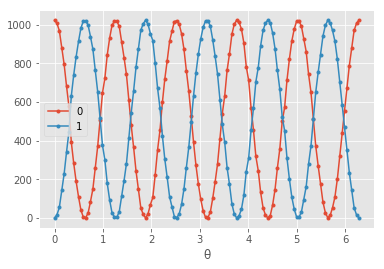

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xlabel('θ')
ax.legend()
plt.show()

### Compilation cost

Compiling over a parameterized circuit prior to binding parameters can, in some cases, significantly reduce compilation time as compared to compiling over the set of bound circuits.

In [ ]:
import time
from itertools import combinations
from qiskit.compiler import transpile
from qiskit.test.mock import FakeTokyo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 64)

for n in theta_range:
    qc = QuantumCircuit(20)

    for k in range(32):
        for i,j in combinations(range(20), 2):
            qc.cx(i,j)
        qc.rz(n, range(20))
        for i,j in combinations(range(20), 2):
            qc.cx(i,j)

    qcs.append(qc)
    
compiled_circuits = transpile(qcs, backend=FakeTokyo())

end = time.time()
print(end-start)

In [ ]:
start = time.time()
qc = QuantumCircuit(20)
theta = Parameter('theta')

for k in range(32):
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)
    qc.rz(theta, range(20))
    for i,j in combinations(range(20), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, {'backend': FakeTokyo()})
compiled_circuits = assemble([transpiled_qc.bind_parameters({theta: n})
                              for n in theta_range], {'backend': FakeTokyo()})
end = time.time()
print(end-start)

### Composition

Parameterized circuits can be composed like standard `QuantumCircuit`s.
Generally, when composing two parameterized circuits, the resulting circuit will be parameterized by the union of the parameters of the source circuits.

However, parameter names must be unique with in a given circuit.
When attemping to add a parameter whose name is already present in the target circuit:
 - if the source and target share the same `Parameter` instance, the parameters will be assumed to be the same and combined
 - if the source and target have different `Parameter` instances, an error will be raised


## Bringing it all together: QPE Demo

In [ ]:
p = Parameter('p')
qc = QuantumCircuit(3)
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}, qr[6:9])
print(larger_qc.draw())

         ┌──────────────────┐
q0_0: |0>┤0                 ├
         │                  │
q0_1: |0>┤1 circuit1(theta) ├
         │                  │
q0_2: |0>┤2                 ├
         └┬────────────────┬┘
q0_3: |0>─┤0               ├─
          │                │
q0_4: |0>─┤1 circuit1(phi) ├─
          │                │
q0_5: |0>─┤2               ├─
         ┌┴────────────────┴┐
q0_6: |0>┤0                 ├
         │                  │
q0_7: |0>┤1 circuit1(gamma) ├
         │                  │
q0_8: |0>┤2                 ├
         └──────────────────┘

print(larger_qc.decompose().draw())
         ┌───────────┐
q0_0: |0>┤ Rz(theta) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐
q0_1: |0>─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q0_2: |0>───────────────────────────────┤ X ├┤ Rz(theta) ├
          ┌─────────┐                   └───┘└───────────┘
q0_3: |0>─┤ Rz(phi) ├───■─────────────────────────────────
          └─────────┘ ┌─┴─┐ ┌─────────┐
q0_4: |0>─────────────┤ X ├─┤ Rz(phi) ├───■───────────────
                      └───┘ └─────────┘ ┌─┴─┐ ┌─────────┐
q0_5: |0>───────────────────────────────┤ X ├─┤ Rz(phi) ├─
         ┌───────────┐                  └───┘ └─────────┘
q0_6: |0>┤ Rz(gamma) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐
q0_7: |0>─────────────┤ X ├┤ Rz(gamma) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q0_8: |0>───────────────────────────────┤ X ├┤ Rz(gamma) ├
                                        └───┘└───────────┘


In [ ]:
>>> qc = qk.QuantumCircuit(3)
>>> qc.cx(0, 1)
<qiskit.extensions.standard.cx.CnotGate object at 0x12842f470>
>>> qc.cx(1, 2)
<qiskit.extensions.standard.cx.CnotGate object at 0x119457898>
>>> shingle = qc.to_instruction()
>>> qc = qk.QuantumCircuit(5)
>>> qr = qc.qregs[0]
>>> qc.append(shingle, [qr[0],qr[1],qr[2]])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> qc.append(shingle, qr[1:4])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> qc.append(shingle, qr[2:5])
<qiskit.circuit.instruction.Instruction object at 0x10c441240>
>>> print(qc)
        ┌────────────┐
q_0: |0>┤0           ├────────────────────────────
        │            │┌────────────┐
q_1: |0>┤1 circuit13 ├┤0           ├──────────────
        │            ││            │┌────────────┐
q_2: |0>┤2           ├┤1 circuit13 ├┤0           ├
        └────────────┘│            ││            │
q_3: |0>──────────────┤2           ├┤1 circuit13 ├
                      └────────────┘│            │
q_4: |0>────────────────────────────┤2           ├
                                    └────────────┘
                        